# Time Seires Analysis of the S&P 500 Intex Closing Price

time series steps:
    1. plot series
    2. eda
    3. test stationarity
    4. decompose time series
    5. model estimation
    6. Transform Data to Adjust for Non-Stationarity
    7. Test for Stationarity
    8. Build a Model 
    9. Forecast

The S&P 500: https://en.wikipedia.org/wiki/S%26P_500_Index

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

%matplotlib inline

In [3]:
import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

from lstm_utils import get_raw_data
from lstm_utils import get_seq_model
from lstm_utils import get_seq_train_test
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1. Get Data

We would utilize the pandas_datareader library to get the required S&P 500 index history using Yahoo Finance databases.
For S&P 500 index, the ticker name is ^GSPC. 
The plot for closing price is depicted below.

In [4]:
STOCK_INDEX = '^GSPC'
sp_df = get_raw_data(STOCK_INDEX)
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3.991400e+09,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2.491020e+09,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4.972660e+09,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5.270680e+09,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4.389590e+09,1144.979980


In [5]:
sp_close_series = sp_df.Close 
sp_close_series.head()

2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Freq: D, Name: Close, dtype: float64

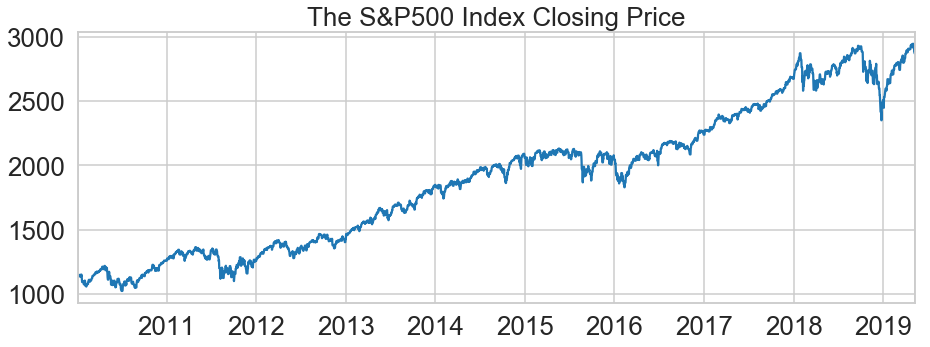

In [6]:
sp_close_series.plot(title = "The S&P500 Index Closing Price")

## 2. Time Series Decomposition

Time series decomposition works by splitting a time series into three components: seasonality, trends and random fluctiation.
- Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.
- Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.
- Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

Visualizing our time-series data enables us to make inferences about important components, such as trend, seasonality, heteroskedasticity, and stationarity.

In [7]:
sp_close_df = pd.DataFrame(sp_close_series)
sp_close_df.reset_index(inplace=True)
sp_close_df.head(7)
#sp_close_df1 = sp_close_df.rename(index=str, columns={"index": "datetime"})
#sp_close_df1.head()

,index,Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980
5,2010-01-09,1144.979980
6,2010-01-10,1144.979980


The frequency of decomposition must be an interval, which 'may' repeat. So we have data with day-to day frequency and we are looking for a weekly repetition of behavior.
We would like to see every season trend and changing pattern of index closing price.

[5, 22, 65, 261]
Time decomposition: weekly, monthly, quaterly, yearly...


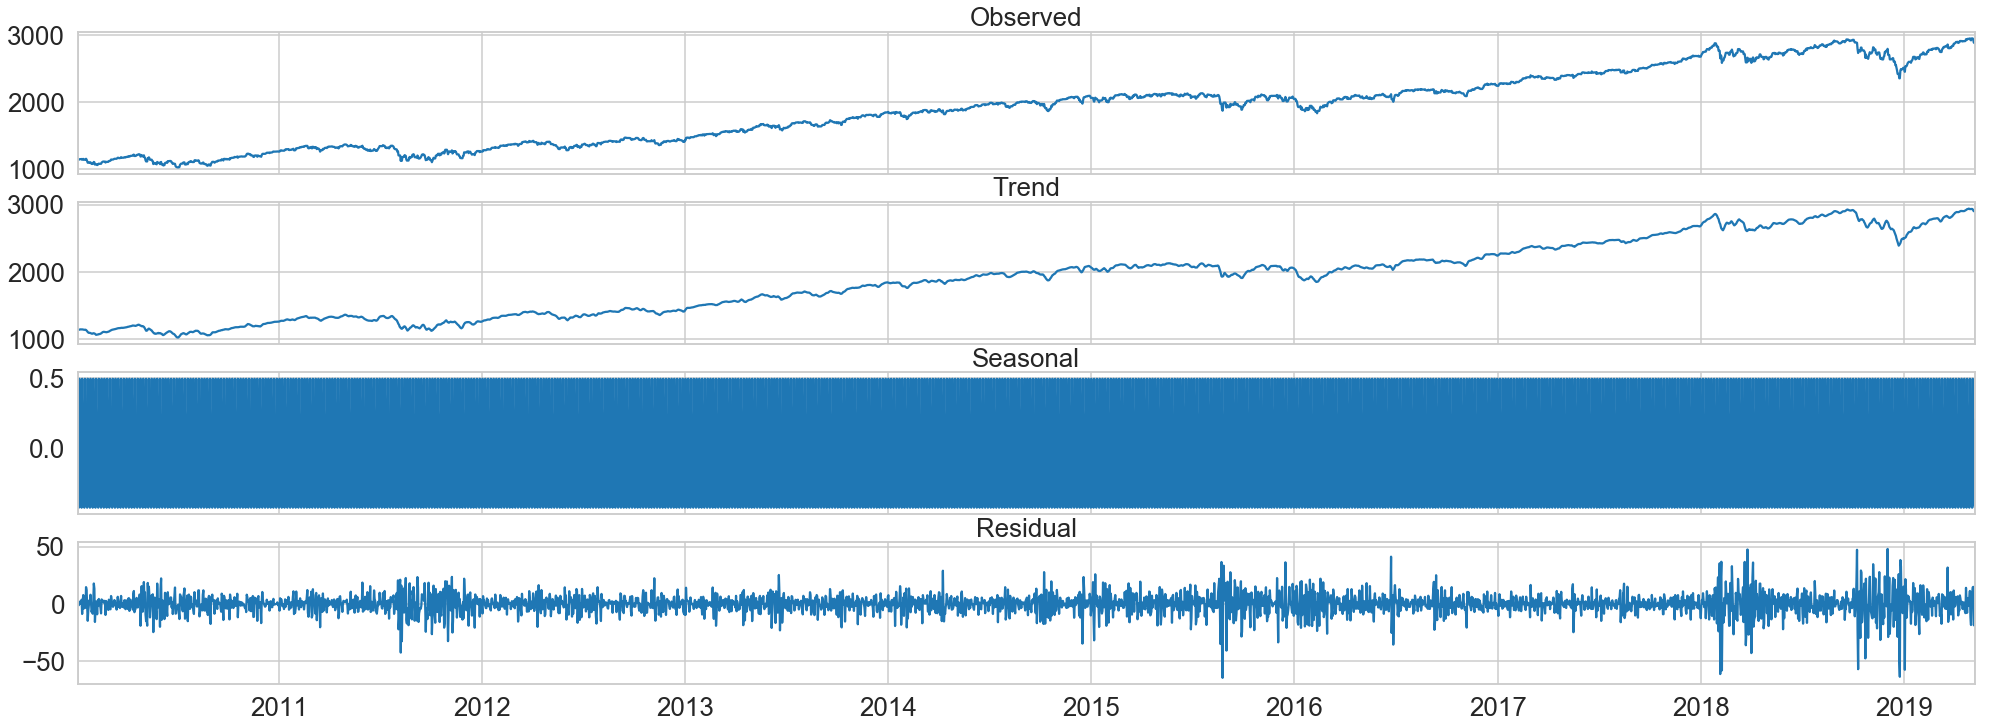

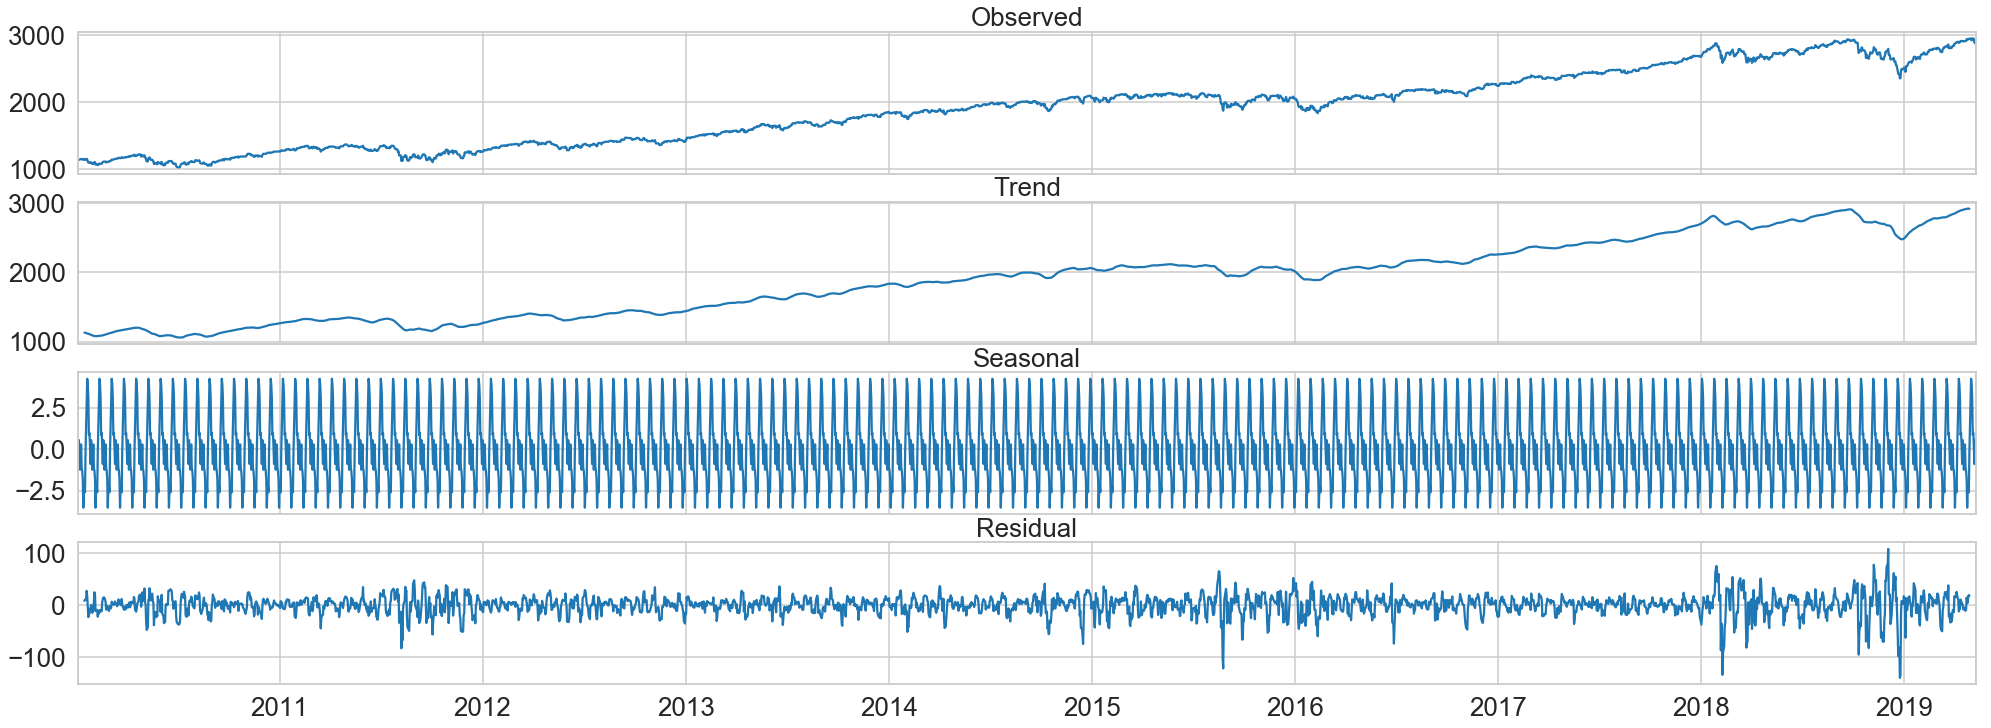

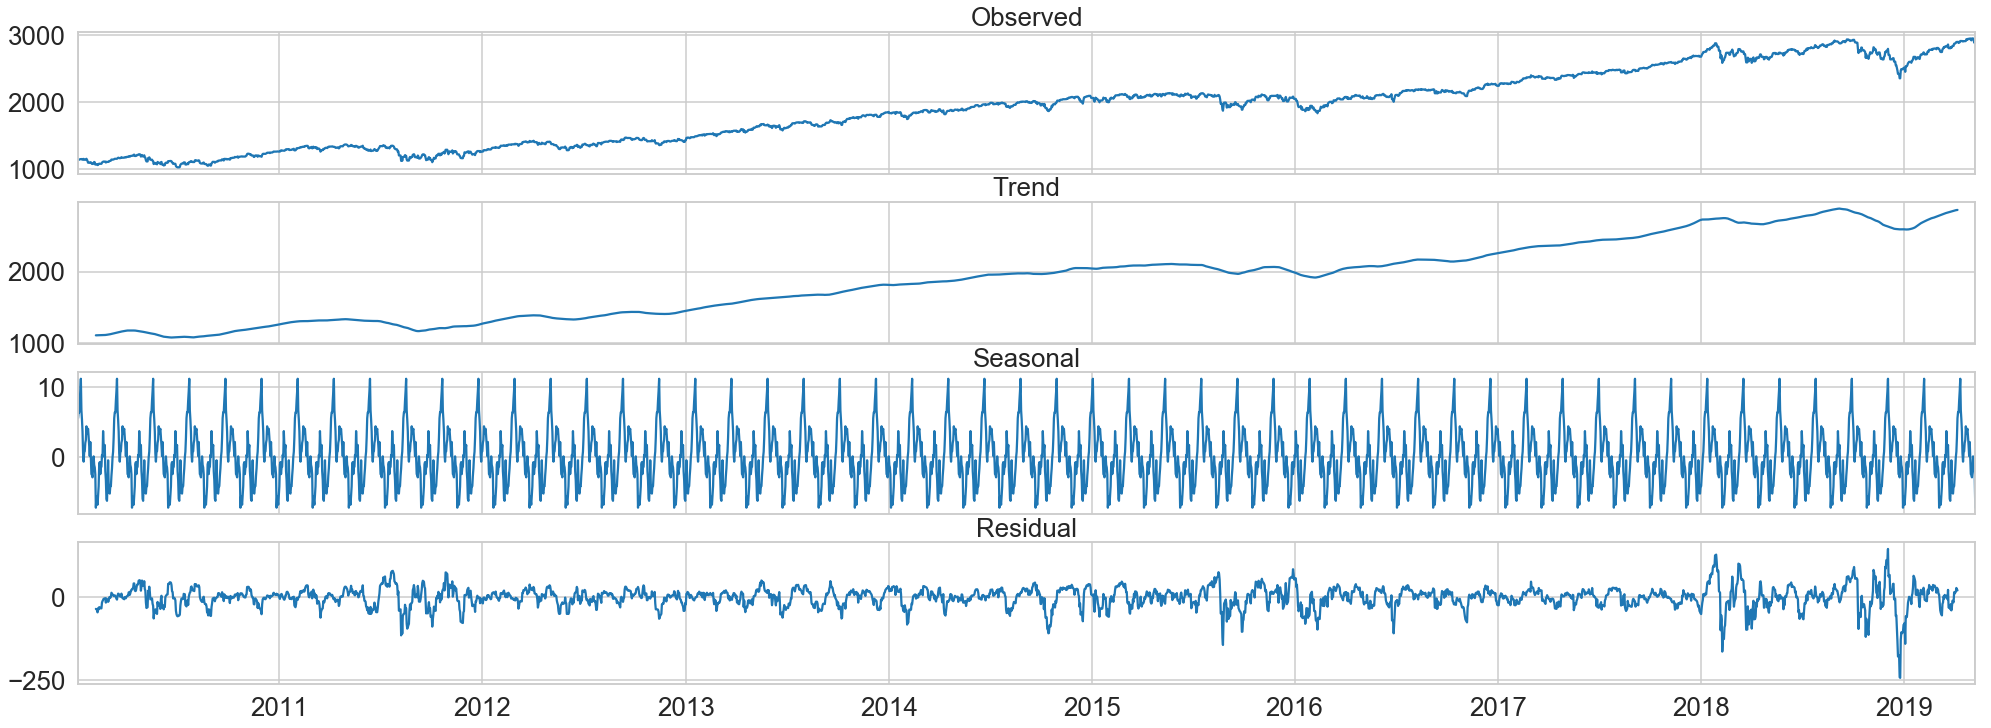

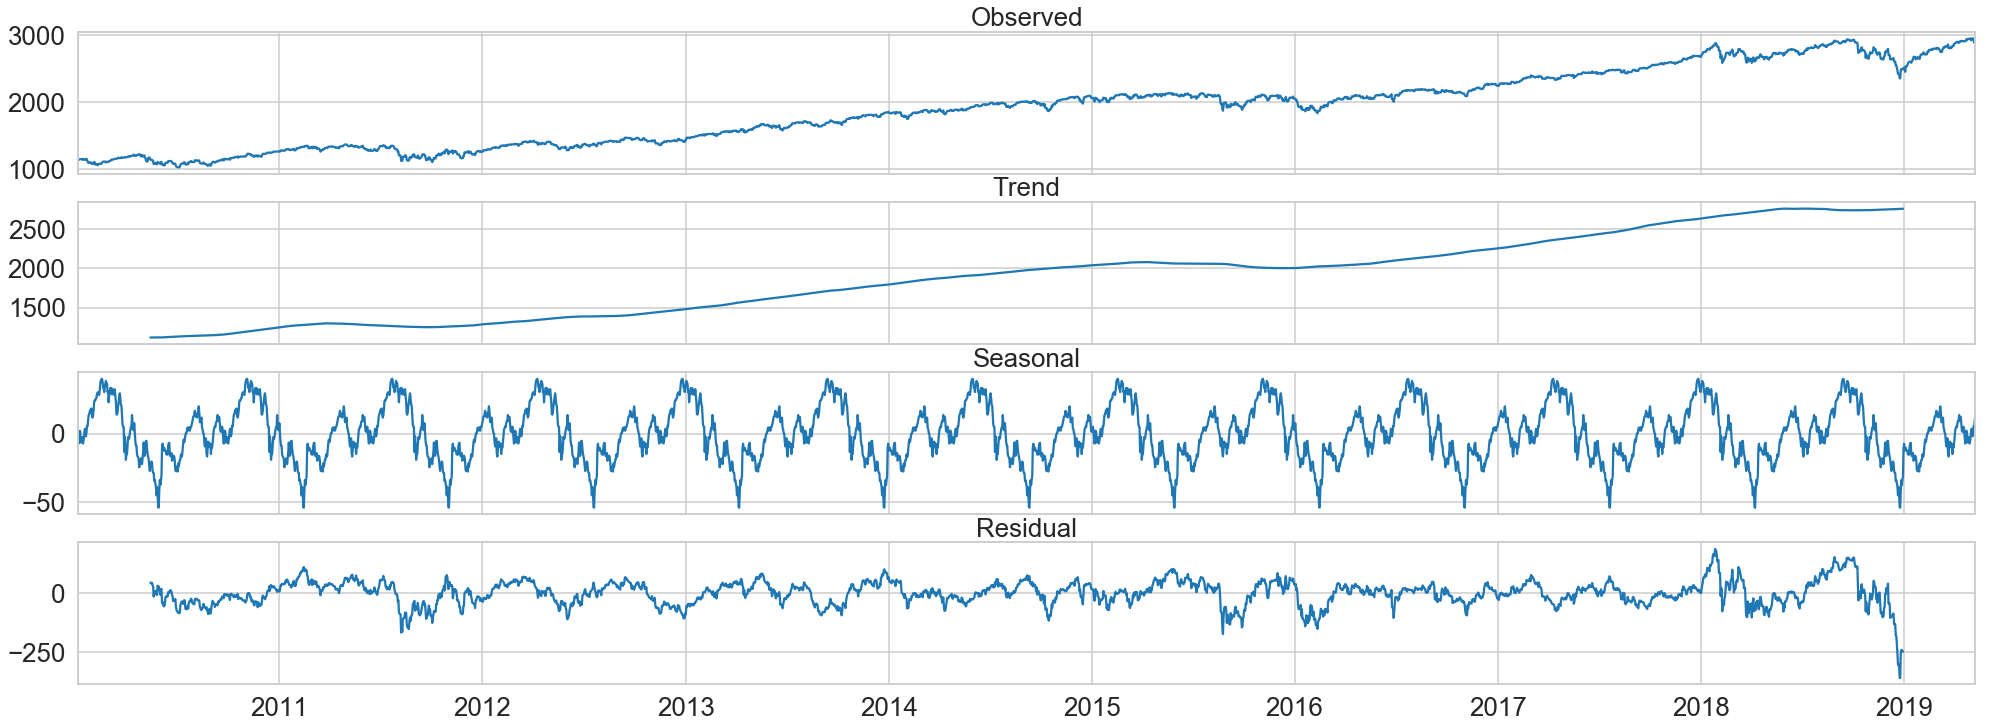

In [8]:
sp_close_df['date_of_transaction'] = pd.to_datetime(sp_close_df['index'])
sp_close_df.head(10)   

trading_days = 365 - 104
week = round(trading_days/52)
month = round(trading_days/12)
quater = round(trading_days/4)
year = trading_days

ts_close = pd.Series(sp_close_df.Close.values,
                    index=pd.date_range(
                                sp_close_df.date_of_transaction.min(),
                                sp_close_df.date_of_transaction.max(),
                                freq='D')
                     )
period_list = [week, month, quater, year]
print(period_list)
print("Time decomposition: weekly, monthly, quaterly, yearly...")

for i in period_list:
    deompose = seasonal_decompose(ts_close.interpolate(), freq = i)
    #deompose.plot()
      
    fig, axs = plt.subplots(4,1, sharex=True, figsize=(34,12))
    deompose.observed.plot(ax=axs[0], title = 'Observed')
    deompose.trend.plot(ax=axs[1], title = 'Trend')
    deompose.seasonal.plot(ax=axs[2], title = 'Seasonal')
    deompose.resid.plot(ax=axs[3], title = 'Residual')

## 3. Simple moving average and exponential smoothing based forecasting¶
     

### Simple Moving Average

moving average: https://en.wikipedia.org/wiki/Moving_average
??? how to select moving average window?

In [9]:
sp_close_df.head(10) 

,index,Close,date_of_transaction
0,2010-01-04,1132.989990,2010-01-04
1,2010-01-05,1136.520020,2010-01-05
2,2010-01-06,1137.140015,2010-01-06
3,2010-01-07,1141.689941,2010-01-07
4,2010-01-08,1144.979980,2010-01-08
5,2010-01-09,1144.979980,2010-01-09
6,2010-01-10,1144.979980,2010-01-10
7,2010-01-11,1146.979980,2010-01-11
8,2010-01-12,1136.219971,2010-01-12
9,2010-01-13,1145.680054,2010-01-13


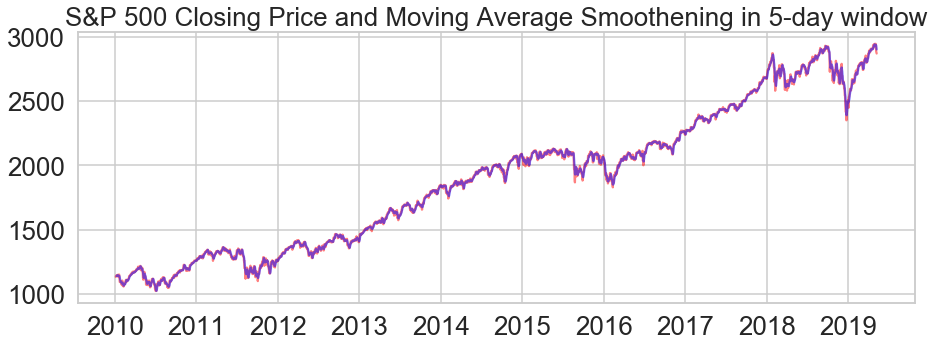

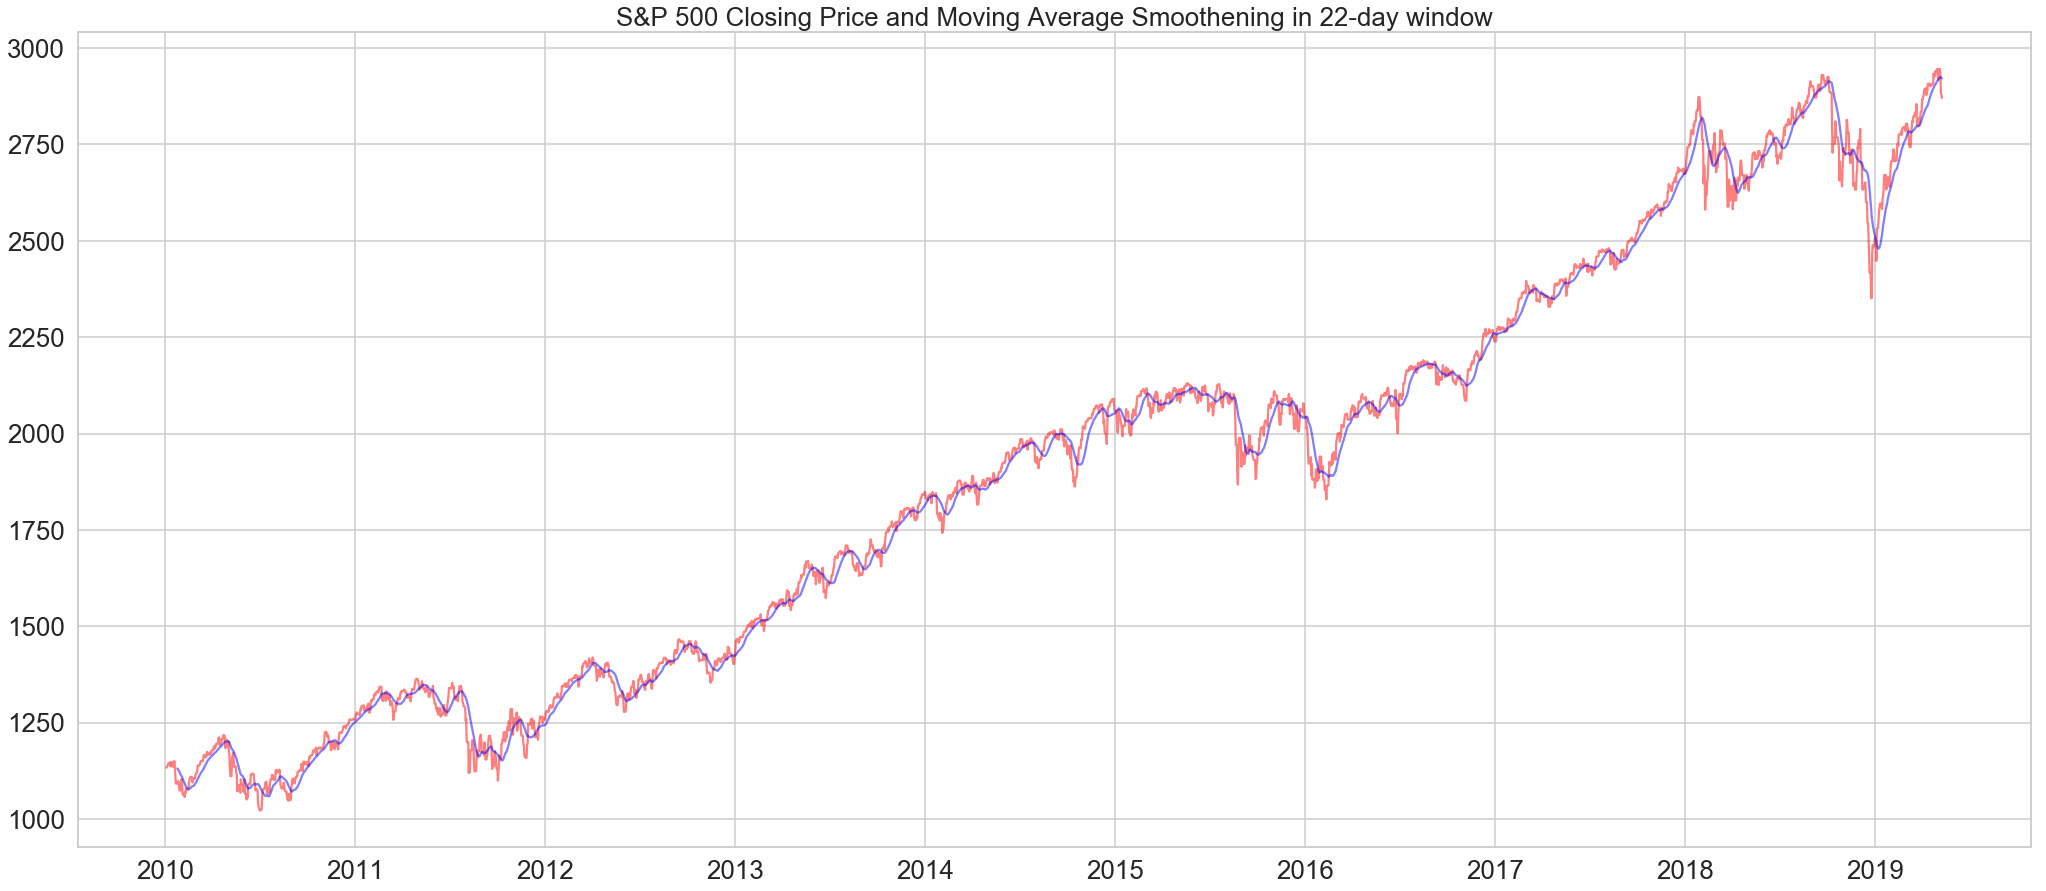

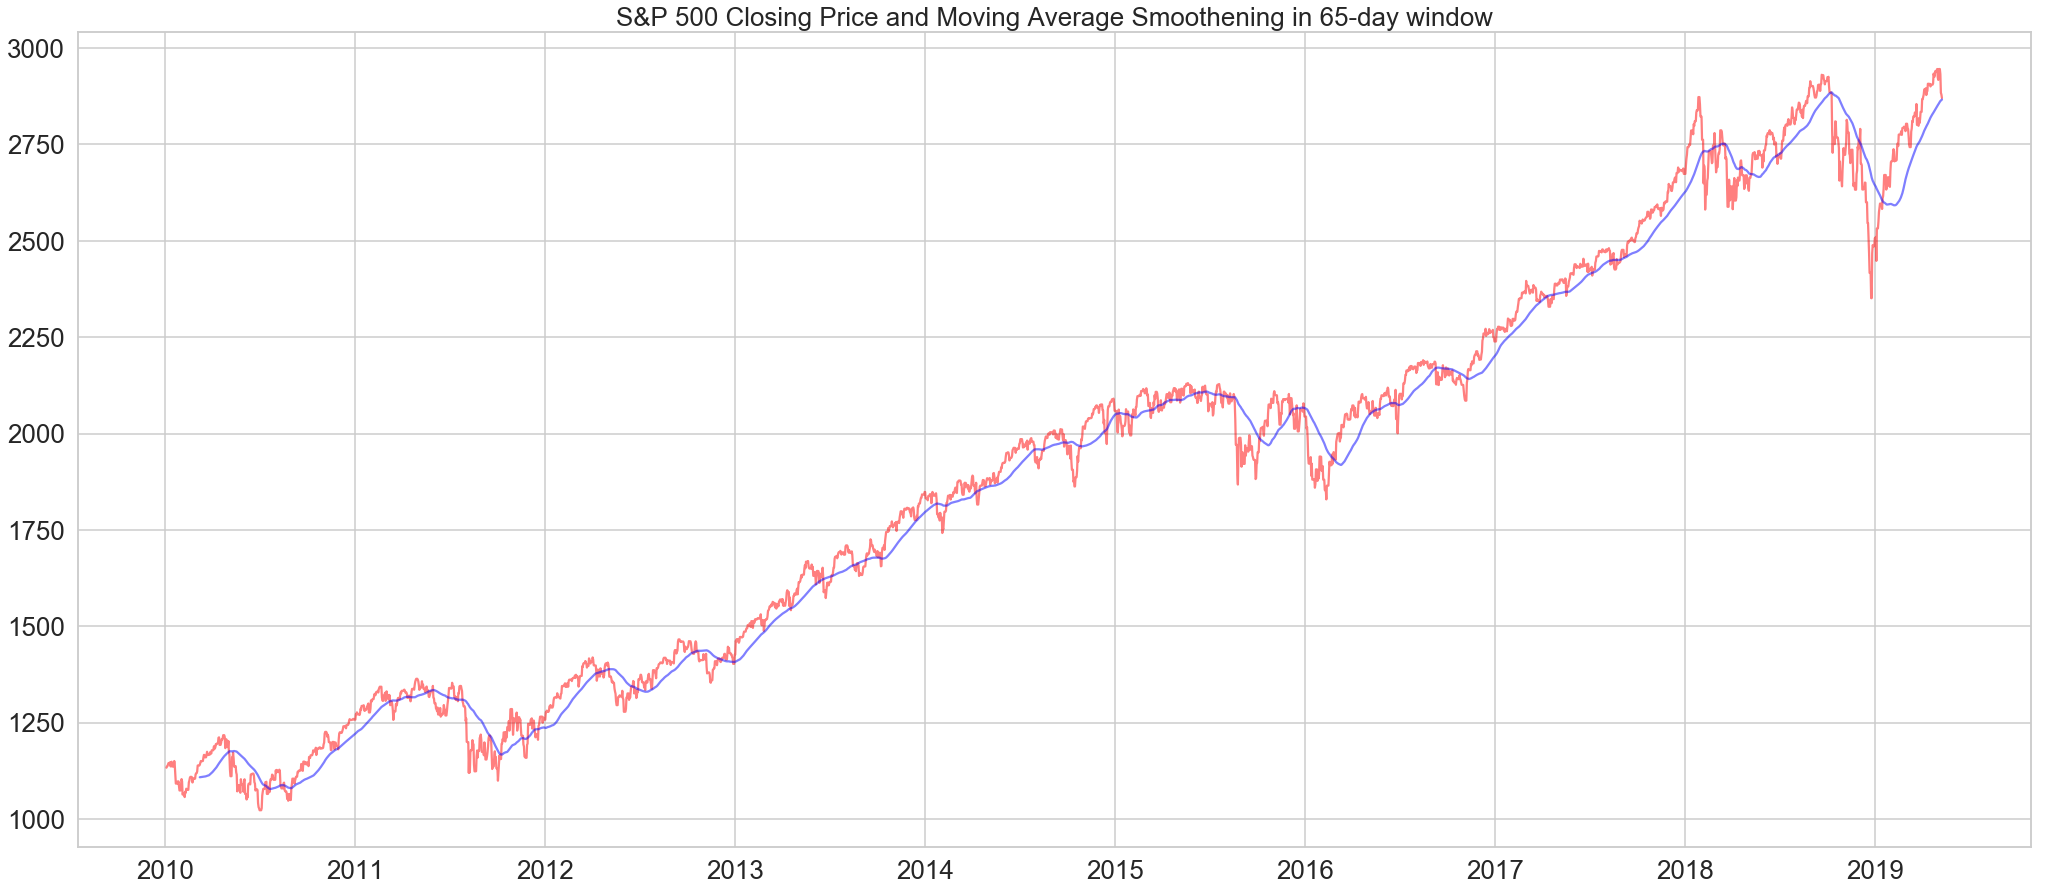

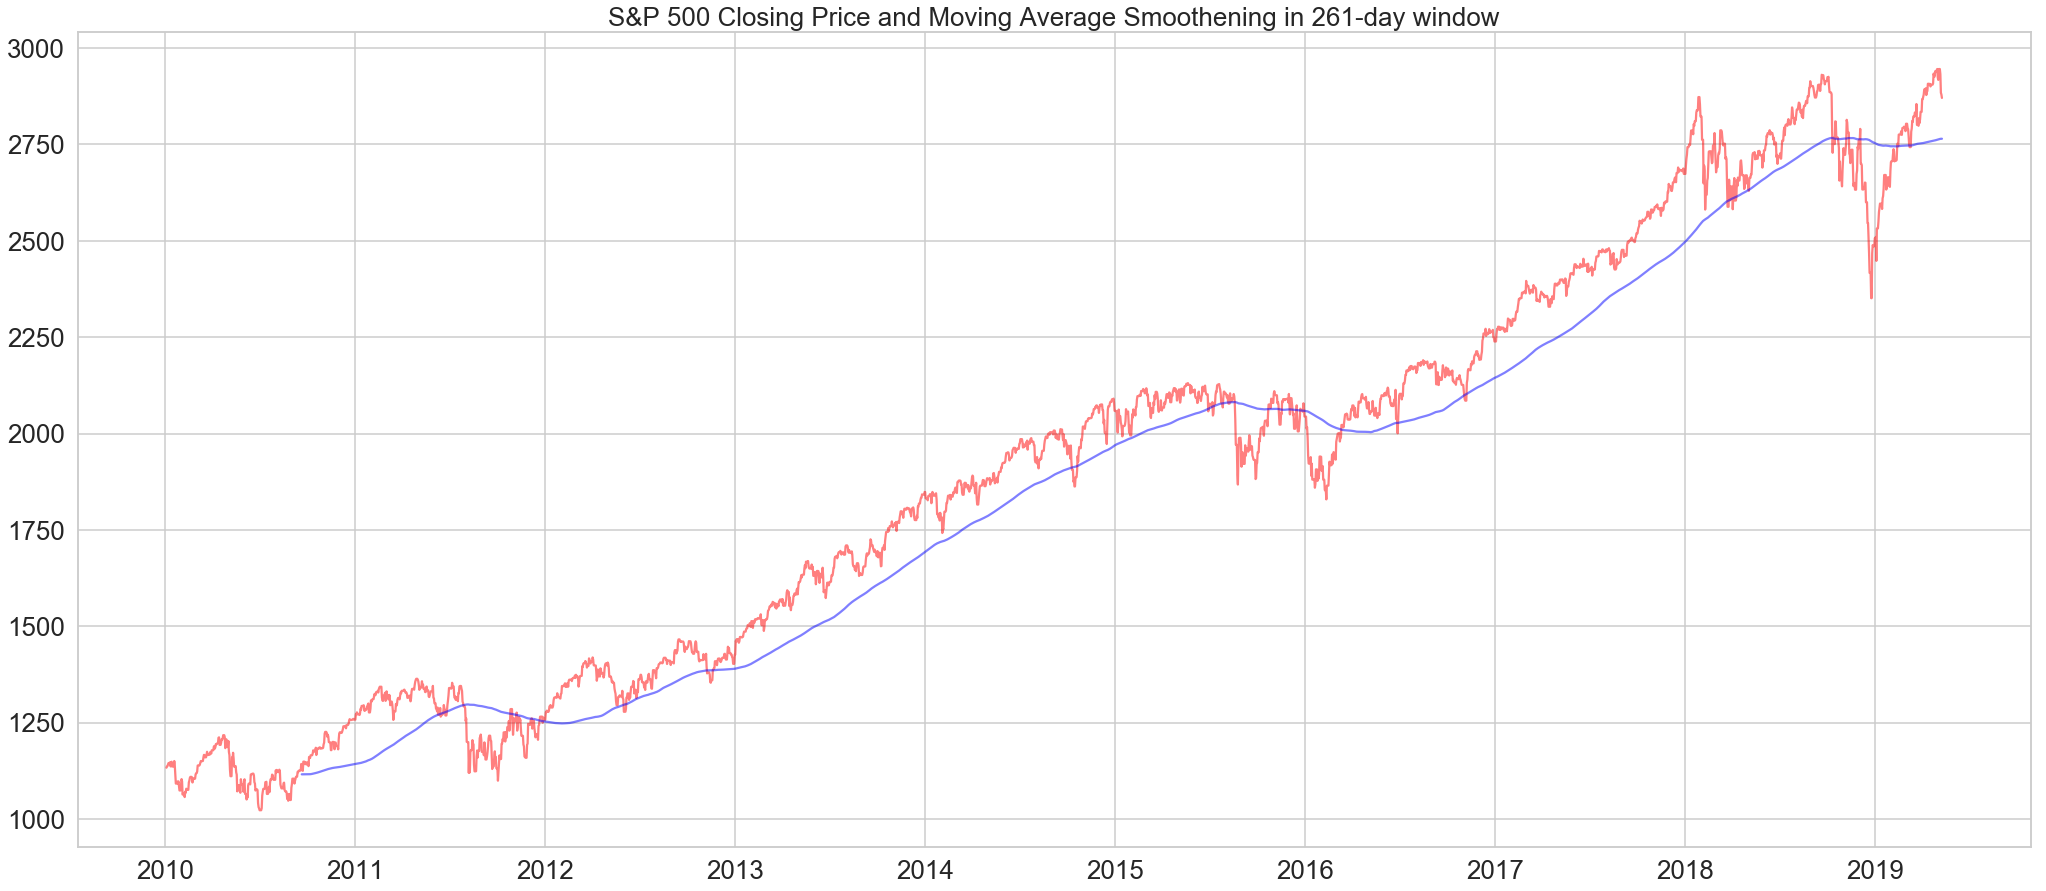

<Figure size 2520x1080 with 0 Axes>

In [10]:
for window in period_list:
    sp_close_df['moving_average'] = sp_close_df['Close'].rolling(window=window,
                                                        center=False).mean()
    #sp_close_df[['Close','moving_average']].head(10)
    #print(sp_close_df.head(5))
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='red',alpha=0.5)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.moving_average, color='b', alpha=0.5)
    plt.title('S&P 500 Closing Price and Moving Average Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))
    #plt.legend()

### Exponential Smoothing¶


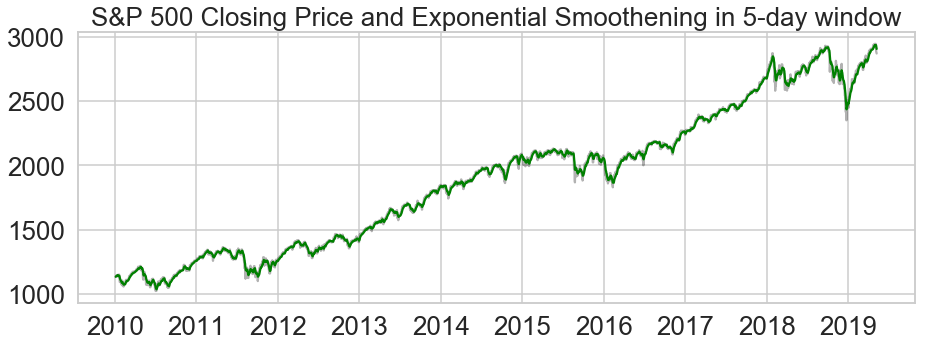

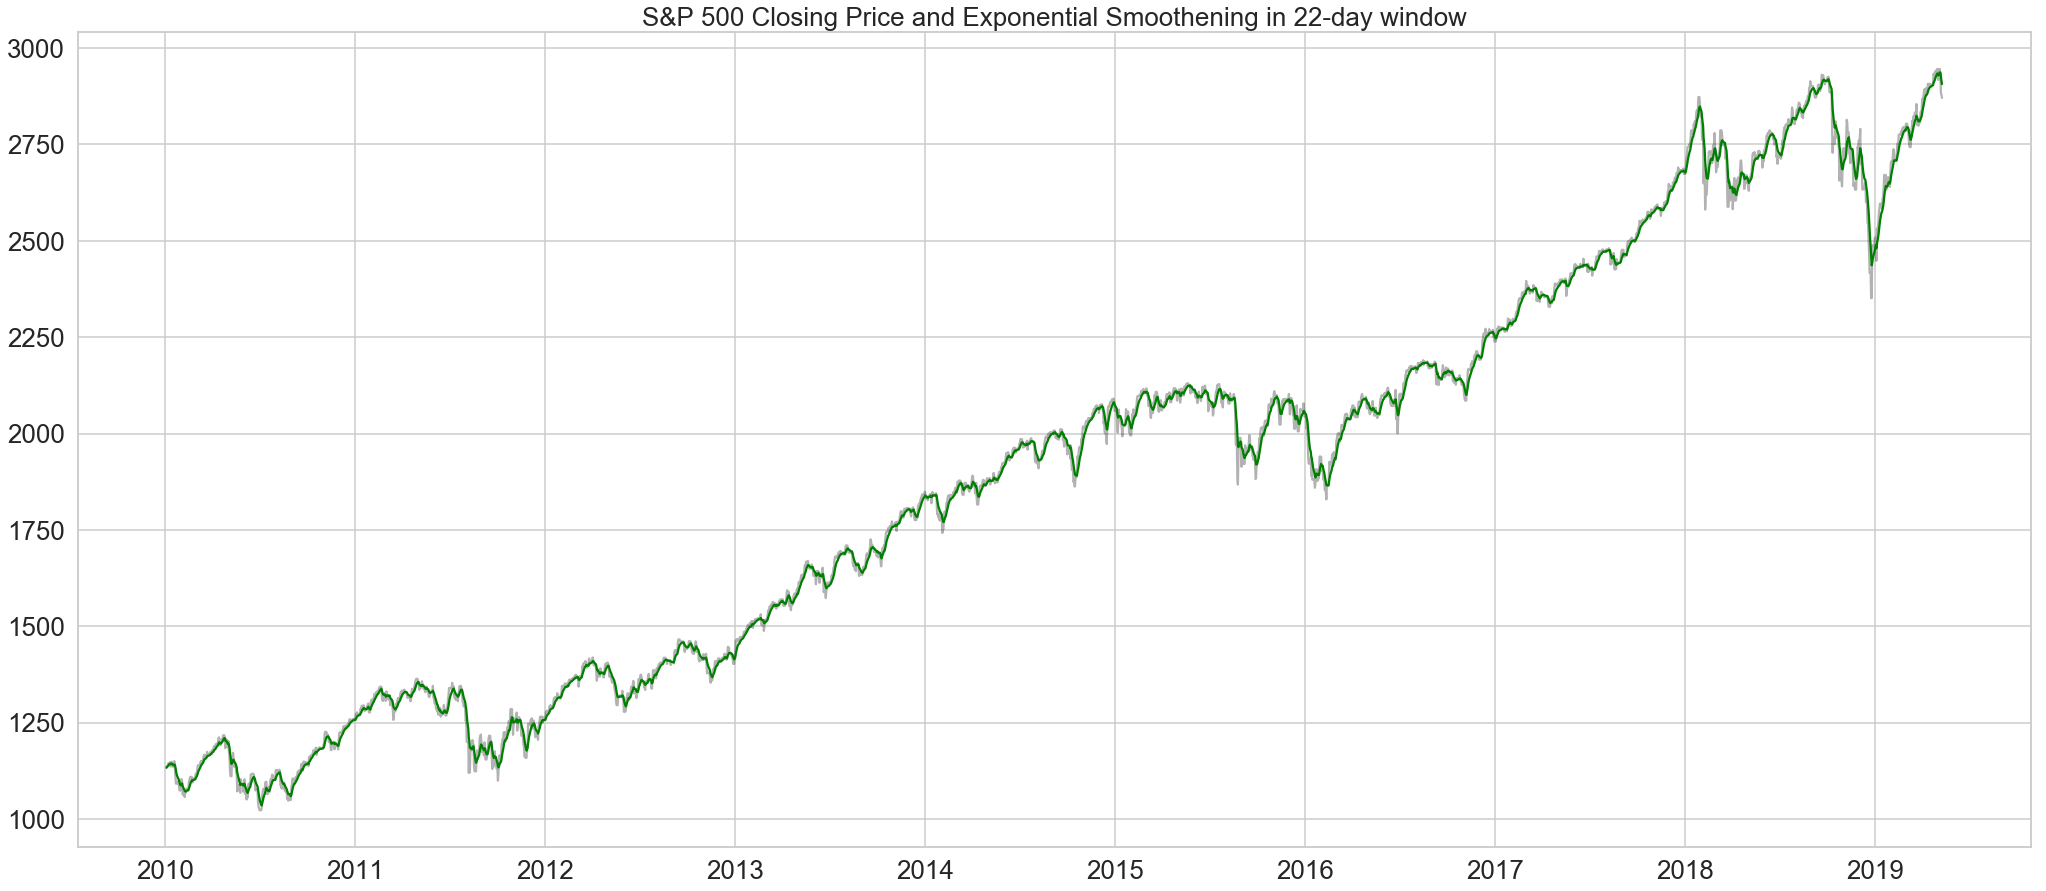

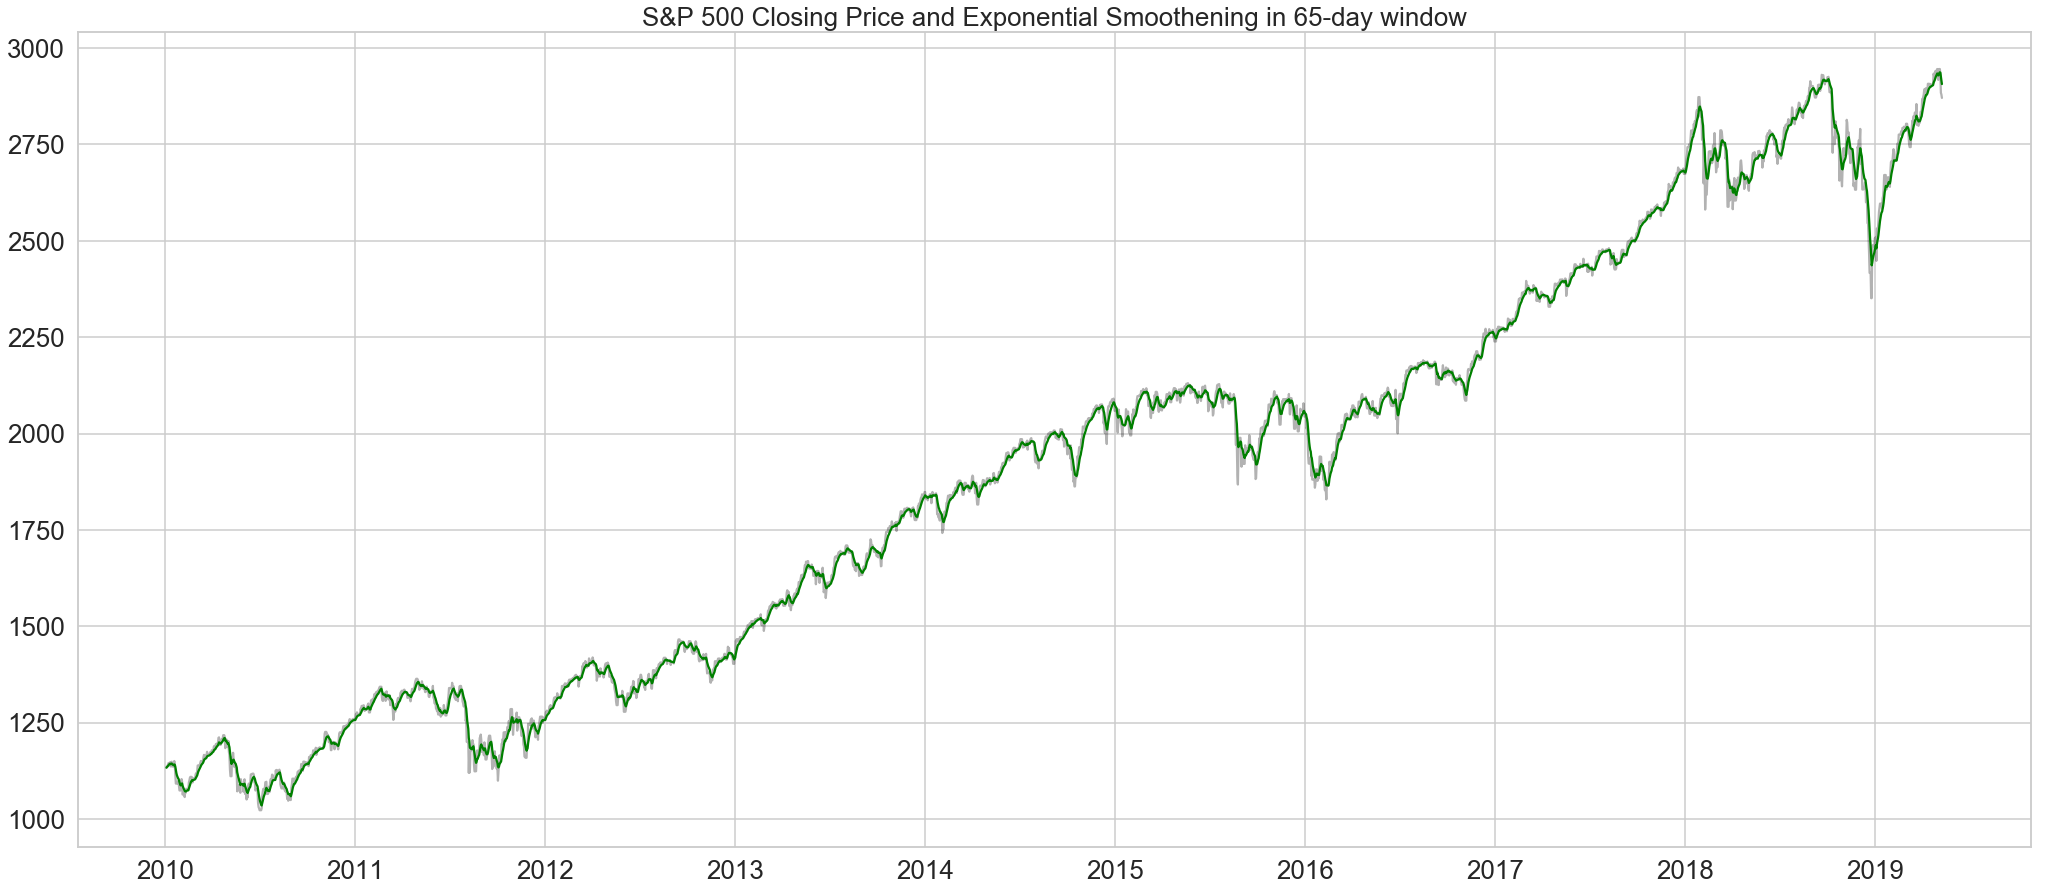

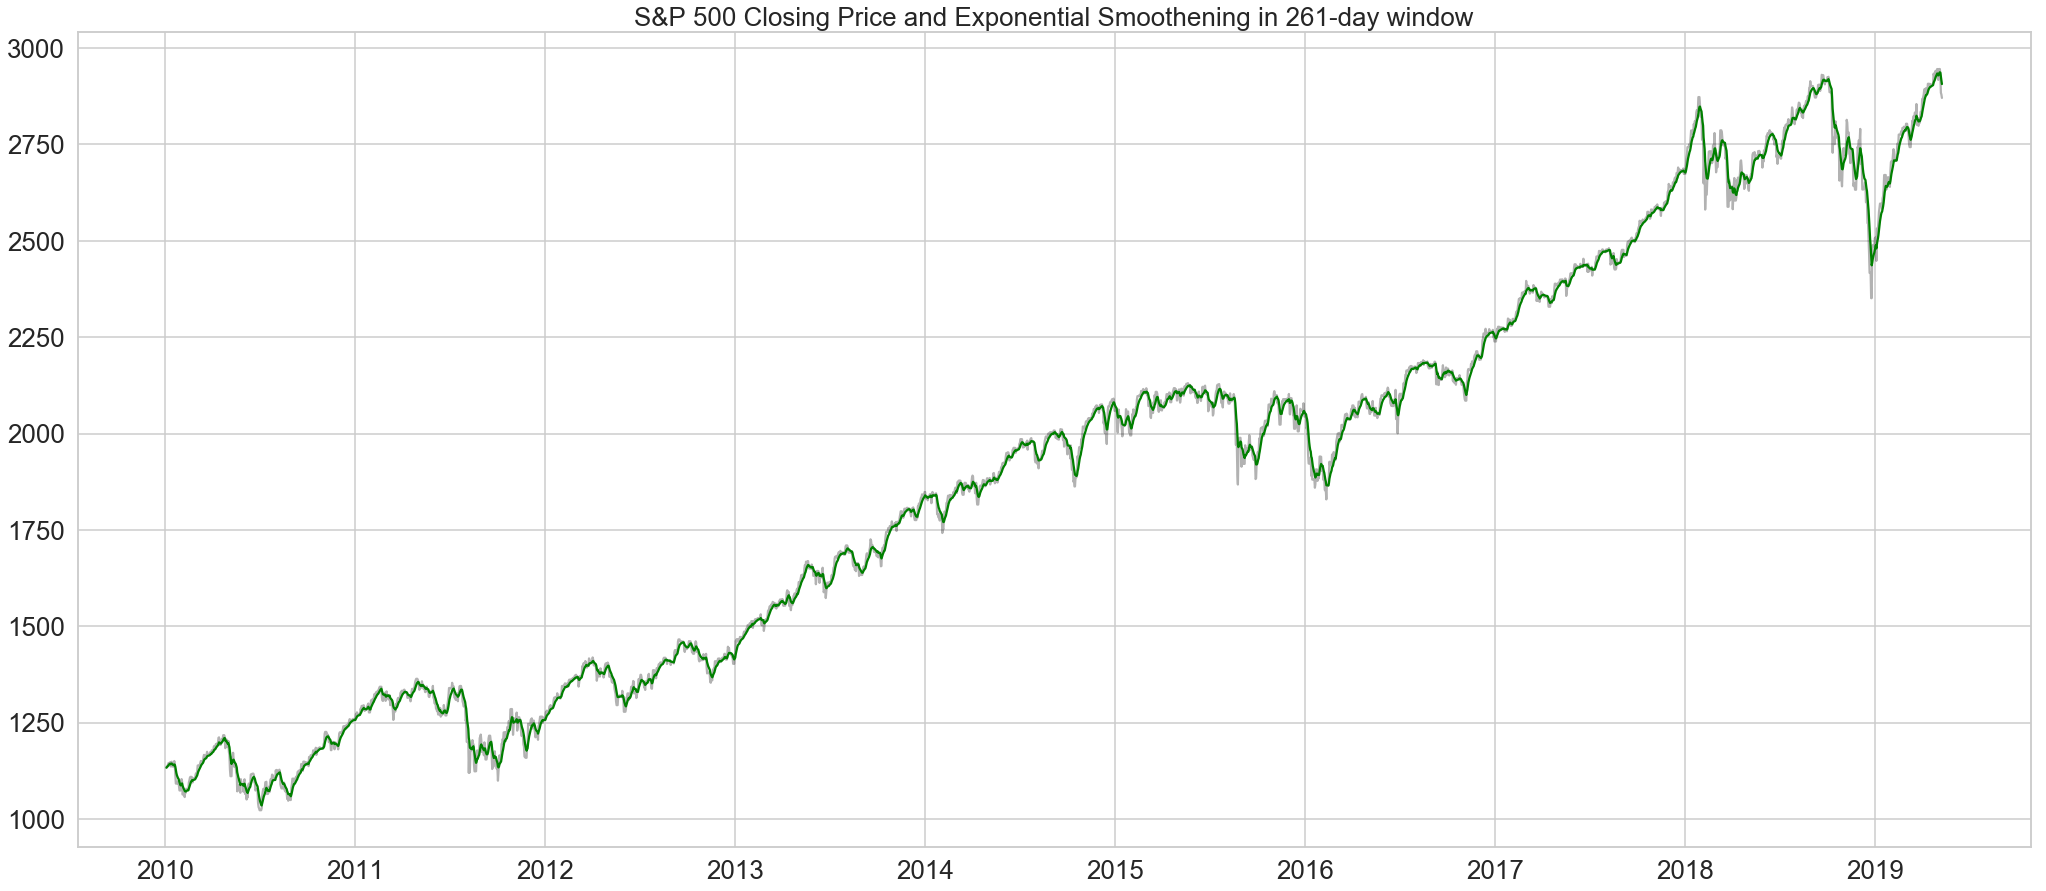

<Figure size 2520x1080 with 0 Axes>

In [11]:
for window in period_list:
    sp_close_df['ewma'] = sp_close_df['Close'].ewm(halflife=3,
                                            ignore_na=False,
                                            min_periods=0,
                                            adjust=True).mean()

    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='black',alpha=0.3)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.ewma,color='g')
    plt.title('S&P 500 Closing Price and Exponential Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))

## References:

1. https://anomaly.io/seasonal-trend-decomposition-in-r/
2. https://www.investopedia.com/articles/active-trading/11/four-types-of-active-traders.asp
3. https://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/TimeSeriesStockAnalysis.ipynb